# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». 

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:
 - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
 - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [1]:
#загрузим необходимые библиотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from seaborn import heatmap

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

<div style="border:solid purple 5px; padding: 20px">
<h2 align="center"> Рубрика «Питонячий лайфхакер» <a class="tocSkip"> </h2>
<h3> Широкоформатный Jupyter <a class="tocSkip"> </h3>
    
Расширяем границы, или как сделать работу более комфортной (не всем нравится 😄)

    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
# загрузим данные, которые нам дали геологи по трем регионам 
region_0 = pd.read_csv('/datasets/geo_data_0.csv')
region_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
region_1 = pd.read_csv('/datasets/geo_data_1.csv')
region_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
region_2 = pd.read_csv('/datasets/geo_data_2.csv')
region_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


изучим общую информацию о всех регионах 

In [5]:
display(region_0.info())
display(region_1.info())
display(region_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Проверим датафреймы на наличие дубликатов

In [6]:
print('Количество дубликатов в регионе 0:', region_0.duplicated().sum())
print('Количество дубликатов в регионе 2:', region_1.duplicated().sum())
print('Количество дубликатов в регионе 3:', region_2.duplicated().sum())

Количество дубликатов в регионе 0: 0
Количество дубликатов в регионе 2: 0
Количество дубликатов в регионе 3: 0


Посмотрим уникальные значения каждого датафрейма

In [7]:
display(region_0.nunique())
display(region_1.nunique())
display(region_2.nunique())

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [8]:
display(region_0.describe())
display(region_1.describe())
display(region_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Существенных выбросов не наблюдается, медианные значения близки к средним 

Чтобы исключить мультиколлениарность, построим матрицы корреляции

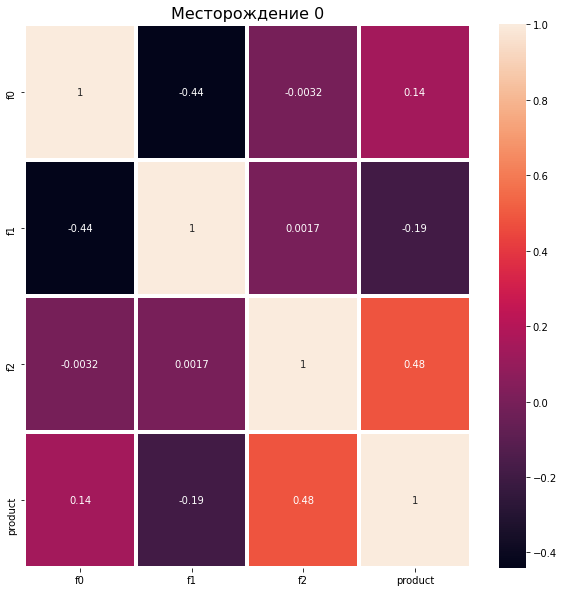

In [9]:
plt.figure(figsize=(10, 10))
plt.title('Месторождение 0', fontsize=16)
heatmap(region_0.corr(), annot = True, linewidths=3);

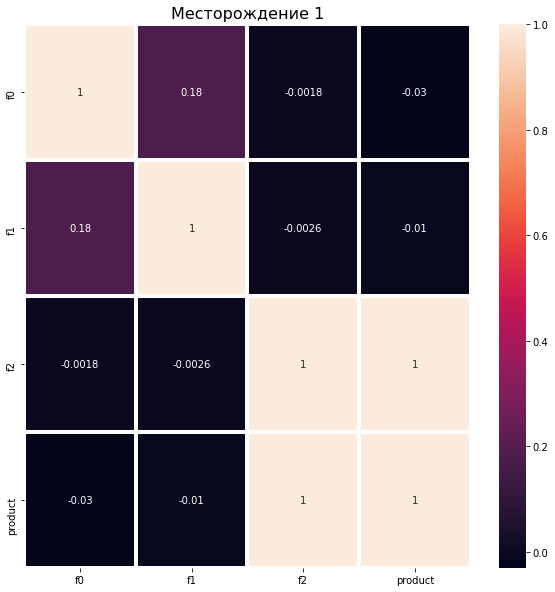

In [10]:
plt.figure(figsize=(10, 10))
plt.title('Месторождение 1', fontsize=16)
heatmap(region_1.corr(), annot = True, linewidths=3);

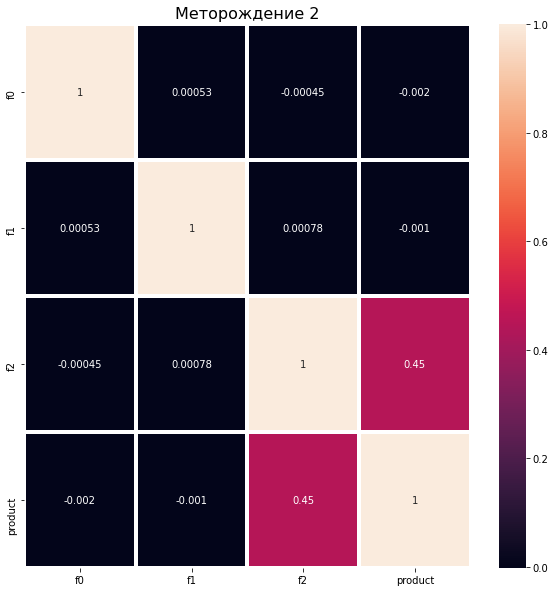

In [11]:
plt.figure(figsize=(10, 10))
plt.title('Меторождение 2', fontsize=16)
heatmap(region_2.corr(), annot = True, linewidths=3);

### Выводы:
- загрузили и изучили данные. В них не наблюдается пропусков и дубликатов, типы данных нормальные
- Существенных выбросов не наблюдается, медианные значения близки к средним
- Корреляции между признаками практически нет. Все признаки не имеют взаимосвязи между собой. У продукта есть прямая зависимость от признака f2, получается, что объем нефти в данном регионе напрямую зависит от этого признака. 

## Обучение и проверка модели

### Подготовка данных

Столбцы с 'id' для дальнейшей работы нам не нужны, удалим их

In [12]:
region_0 = region_0.drop('id', axis=1)
region_1 = region_1.drop('id', axis=1)
region_2 = region_2.drop('id', axis=1)

Для дальнейшей работы необходимо подготовить данные. Работаем с 3 регионами, поэтому для удобства напишем функцию для выделения признаков и разбиения данных на выборки

In [13]:
 def pred_region(data):
    features = data.drop('product', axis=1)
    target = data['product']
    #по условия задания разобъем выборки в масштабе 3 к 1
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                                  test_size=0.25, random_state=2222222)
    scaler = StandardScaler()
    scaler.fit(features_train)
    
    features_train = pd.DataFrame(scaler.transform(features_train),
                                  index=target_train)
    features_valid = pd.DataFrame(scaler.transform(features_valid),
                                  index=target_valid)
    return features_train, features_valid, target_train, target_valid     

In [14]:
# получим features и target для 3 регионов
features_train_0, features_valid_0, target_train_0, target_valid_0 = pred_region(region_0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = pred_region(region_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = pred_region(region_2)

Проверим размер обучающей и тестовой выборок для каждого из регионов

In [15]:
# для региона 0
print('Размер обучающей выборки:', features_train_0.shape)
print('Размер тестовой выборки:', features_valid_0.shape)

Размер обучающей выборки: (75000, 3)
Размер тестовой выборки: (25000, 3)


In [16]:
# для региона 1
print('Размер обучающей выборки:', features_train_1.shape)
print('Размер тестовой выборки:', features_valid_1.shape)

Размер обучающей выборки: (75000, 3)
Размер тестовой выборки: (25000, 3)


In [17]:
# для региона 2
print('Размер обучающей выборки:', features_train_2.shape)
print('Размер тестовой выборки:', features_valid_2.shape)

Размер обучающей выборки: (75000, 3)
Размер тестовой выборки: (25000, 3)


### Обучение модели

Далее обучим модель линейной регрессии и сделаем предсказания на валидационной выборке

Для простоты кода, напишем функцию для получения результатов моделирования

In [18]:
def model(features_train, features_valid, target_train, target_valid):
    
    model = LinearRegression() # используем модель LinearRegression
    #обучим модель на тренировочной выборке
    model.fit(features_train, target_train)
    #получим предсказангия на валидационной выборке
    predictions_valid = pd.Series(model.predict(features_valid)) 
    #посчитаем метрику RMSE
    rmse = mean_squared_error(target_valid, predictions_valid)**0.5 
    mean_pred_pr = predictions_valid.mean()
    
    return predictions_valid, rmse, mean_pred_pr

Найдем данные по всем регионам

In [19]:
predictions_valid_0, rmse_0, mean_pred_pr_0 = model(features_train_0, features_valid_0, target_train_0, target_valid_0)
predictions_valid_1, rmse_1, mean_pred_pr_1 = model(features_train_1, features_valid_1, target_train_1, target_valid_1)
predictions_valid_2, rmse_2, mean_pred_pr_2 = model(features_train_2, features_valid_2, target_train_2, target_valid_2)

Выведем на экран средний запас предсказанного сырья и RMSE модели

In [20]:
print('средний запас предсказанного сырья региона 0: {:.2f}, RMSE модели {:.2f}'.format(mean_pred_pr_0, rmse_0))
print('средний запас предсказанного сырья региона 1: {:.2f}, а RMSE модели {:.2f}'.format(mean_pred_pr_1, rmse_1))
print('средний запас предсказанного сырья региона 2: {:.2f}, а RMSE модели {:.2f}'.format(mean_pred_pr_2, rmse_2))

средний запас предсказанного сырья региона 0: 92.35, RMSE модели 37.61
средний запас предсказанного сырья региона 1: 68.71, а RMSE модели 0.89
средний запас предсказанного сырья региона 2: 95.09, а RMSE модели 39.93


Выведем на экран реальный запас сырья

In [21]:
print('реальный запас сырья в регионе 0: {:.2f}'.format(target_valid_0.mean()))
print('реальный запас сырья в регионе 1: {:.2f}'.format(target_valid_1.mean()))
print('реальный запас сырья в регионе 2: {:.2f}'.format(target_valid_2.mean()))

реальный запас сырья в регионе 0: 92.56
реальный запас сырья в регионе 1: 68.70
реальный запас сырья в регионе 2: 94.79


### Выводы
- все модели предсказывают значения близкие к истинным, значени отличаются слабо
- регионы 0 и 2 имеют достаточно похожие значения друг к другу, меторождение региона 1 имеет меньший запас сырья
- модель региона 1 показала наилучший результат RMSE. Ошибка на этом месторождении всего 0,89 тыс. баррелей, что выглядит достаточно странно, возможно это связано с тем, что признак f2 имеет прямую зависимость с целевым признаком и определяет поведение модели

## Подготовка к расчёту прибыли

### Зададим значения, указанные в условии задачи

In [22]:
budget = 10**10  # объем бюджет на разработку скважин (руб)
min_point = 500 # количество точек для разработки
best_point = 200  # Количесвто лучших точек, выбранных для разработки
prise = 450000 # доход с 1 тыс баррель (руб)
loss_probability = 0.025 # максимальная вероятность убытков (отн. ед.)
Bootstrap = 1000

Для начала необходимо посчитать необходимый минимальный объем добычи месторождения, чтобы оно отбивало хотя бы себестоимость

In [23]:
min_volume = budget / prise / best_point
print('минимально необходимый объем сырья для безубыточной разработки новой скважины {:.2f} тыс. баррелей'.format(min_volume))

минимально необходимый объем сырья для безубыточной разработки новой скважины 111.11 тыс. баррелей


### Вывод
Для того, чтобы можно работать на месторождении было выгодно, нужно, чтобы в среднем в скважинах было больше 111.1 тыс. баррелей нефти. Во всех регионах данное значение ниже. Значит, нам необходимо выбрать наиболее выгодные точки для дальнейшей работы у каждого из регионов и уже сравнивать их между собой

## Расчёт прибыли и рисков 

Произведем расчет прибыли 200 самых привлекательных скважин с максимальными значениями предсказаний. Для этих скважин найдем значения и проведем по ним расчет прибыли. Создадим функцию. 

In [24]:
def profit_calc(target_valid, predictions_valid):
    # отберем 200 скважин с максимальным объемом нефти
    pred_choice = predictions_valid.sort_values(ascending=False).head(200) 
    target_choice = target_valid.reset_index(drop=True)[pred_choice.index] 
    profit = target_choice.sum() * prise
    return profit

In [25]:
print('прибыль с 200 выбранных меделью скважин для региона 0 - {:.3f} руб.'.format(profit_calc(target_valid_0, predictions_valid_0) - budget))
print('прибыль с 200 выбранных меделью скважин для региона 1 - {:.3f} руб.'.format(profit_calc(target_valid_1, predictions_valid_1) - budget))
print('прибыль с 200 выбранных меделью скважин для региона 2 - {:.3f} руб.'.format(profit_calc(target_valid_2, predictions_valid_2) - budget))

прибыль с 200 выбранных меделью скважин для региона 0 - 3123435859.614 руб.
прибыль с 200 выбранных меделью скважин для региона 1 - 2415086696.682 руб.
прибыль с 200 выбранных меделью скважин для региона 2 - 2687028804.849 руб.


### Вывод:
- Мы наблюдаем очень высокое значение прибыли для каждого из регионов, от 2.6 до 3.1 млрд руб., однако это будет в случае если будет производиться добыча по всем точкам. Согласно условию задачи, разведку возможно произвести только по 500 точкам, а разработать всего 200 наилучших месторождений. Необходимо выбрать лучшие месторождения, исходя из ограничений. Напишем функцию.

In [26]:
def revenue (target_valid, predictions_valid, min_point):
    pred_choice = predictions_valid.sort_values(ascending=False)
    
    # определим верные знгачения для отобраных скважин
    target_choice = target_valid[pred_choice.index][:min_point]
    income = target_choice.sum() * prise # доход в рублях
    return income

In [27]:
# создадим функцию для каждого региона
def income_distribution (predictions_valid, target_valid, Bootstrap, min_point):
    state = np.random.RandomState(2222222)
    count = 0 

    values = []
    
    for i in range(Bootstrap):
        target_subsample = target_valid.reset_index(drop=True).sample(min_point, replace=True, random_state=state)
        probs_subsample = predictions_valid[target_subsample.index]
        rev = revenue(target_subsample, probs_subsample, best_point) - budget
        values.append(rev)
        #проверяем выборку на убыточность, если является таковой, то увеличиваем счетчик
        if rev < 0:
            count +=1
    values = pd.Series(values)
    
    #посчитаем и выведем среднее значение выручки
    mean = values.mean()
    print("Среднее значение выручки:", mean, 'рублей')
    # посчитаем и выведем 95-% доверительный интервал
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), np.std(values, ddof=1))
    print("95%-ый доверительный интервал:", confidence_interval)
    pvalue = 1. * count / Bootstrap
    if pvalue < loss_probability:
        print("Вероятность убытка {:.2%}, что меньше допустимой по условиям задачи, значит регион нам подходит".format(pvalue))
    else:
        print("Вероятность убытка {:.2%}, что больше допустимой по условиям задачи, регион нам не подходит".format(pvalue))
    # левая граница доверительного интервала
    one_x12, one_y12 = [confidence_interval[0],confidence_interval[0]], [0, 30]
    # правая граница доверительного интервала
    two_x12, two_y12 = [confidence_interval[1],confidence_interval[1]], [0, 30]

In [28]:
from scipy import stats as st # для доверительного интервала

In [29]:
print('Для региона №0 при случайном выборе 500 скважин получаются следующие показатели')
income_distribution (predictions_valid_0, target_valid_0, Bootstrap, min_point)

Для региона №0 при случайном выборе 500 скважин получаются следующие показатели
Среднее значение выручки: 438299260.14033836 рублей
95%-ый доверительный интервал: (-102926998.97528344, 979525519.2559602)
Вероятность убытка 5.10%, что больше допустимой по условиям задачи, регион нам не подходит


In [30]:
print('Для региона №1 при случайном выборе 500 скважин получаются следующие показатели')
income_distribution (predictions_valid_1, target_valid_1, Bootstrap, min_point)

Для региона №1 при случайном выборе 500 скважин получаются следующие показатели
Среднее значение выручки: 495023502.0275886 рублей
95%-ый доверительный интервал: (75613820.79878777, 914433183.2563894)
Вероятность убытка 1.30%, что меньше допустимой по условиям задачи, значит регион нам подходит


In [31]:
print('Для региона №2 при случайном выборе 500 скважин получаются следующие показатели')
income_distribution (predictions_valid_2, target_valid_2, Bootstrap, min_point)

Для региона №2 при случайном выборе 500 скважин получаются следующие показатели
Среднее значение выручки: 406619450.84611785 рублей
95%-ый доверительный интервал: (-128485621.40717942, 941724523.0994151)
Вероятность убытка 7.20%, что больше допустимой по условиям задачи, регион нам не подходит


### Выводы
- На основе приведенного анализа, можно предположить, что наиболее выгодный реогион для разработки месторождения - регион №1
- Регион №1 показал лучшее среднее значение выручки - 495023502.0275886 рублей
- 95%-ый доверительный интервал: 75613820.79878777, 914433183.2563894
- вероятность получения убытка всего 1.3%, что подходит нам по условию задачи. 
- в двух других регионах вероятность получения убытка значительно выше - 5.1% и 7.2% соответственно, также у них меньше значение средней выручки. 
Одназначно стоит выбрать для дальнейшей работы регион №1. 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован